In [1]:
import pandas as pd
import numpy as np
from glob import glob
from scipy import stats
from sae_lens.toolkit.pretrained_saes import get_gpt2_res_jb_saes
import json
import random
import matplotlib.pyplot as plt
from typing import List, Dict, Tuple
from transformer_lens import HookedTransformer
import torch
from jaxtyping import Float, Int
from collections import defaultdict
from sklearn.decomposition import TruncatedSVD
import itertools
import torch.nn.functional as F
import math
import seaborn as sns

## Setup

In [2]:
def get_device_str() -> str:
    if torch.backends.mps.is_available():
        return "mps"
    else:
        return "cuda" if torch.cuda.is_available() else "cpu"


def comp_js_divergence(
    p_logit: Float[torch.Tensor, "*batch vocab"],
    q_logit: Float[torch.Tensor, "*batch vocab"],
) -> Float[torch.Tensor, "*batch"]:
    p_logprob = torch.log_softmax(p_logit, dim=-1)
    q_logprob = torch.log_softmax(q_logit, dim=-1)
    p = p_logprob.exp()
    q = q_logprob.exp()

    # convert to log2
    p_logprob *= math.log2(math.e)
    q_logprob *= math.log2(math.e)

    m = 0.5 * (p + q)
    m_logprob = m.log2()

    p_kl_div = (p * (p_logprob - m_logprob)).sum(-1)
    q_kl_div = (q * (q_logprob - m_logprob)).sum(-1)

    assert p_kl_div.isfinite().all()
    assert q_kl_div.isfinite().all()
    return (p_kl_div + q_kl_div) / 2

In [3]:
model = HookedTransformer.from_pretrained("gpt2")
device = get_device_str()

print(device)

Loaded pretrained model gpt2 into HookedTransformer
cuda


In [4]:
perturbation_layer = "blocks.0.hook_resid_pre"
saes, sparsities = get_gpt2_res_jb_saes(perturbation_layer)
sae = saes[perturbation_layer].cpu()
feature_sparsities = 10 ** sparsities[perturbation_layer].cpu()

sae.eval()

100%|██████████| 1/1 [00:00<00:00,  1.39it/s]


SAE(
  (activation_fn): ReLU()
  (hook_sae_input): HookPoint()
  (hook_sae_acts_pre): HookPoint()
  (hook_sae_acts_post): HookPoint()
  (hook_sae_output): HookPoint()
  (hook_sae_recons): HookPoint()
  (hook_sae_error): HookPoint()
)

In [5]:
def load_jsonl(file_path):
    data = []
    with open(file_path, "r") as file:
        for line in file:
            # Parse each line as a JSON object
            json_object = json.loads(line.strip())
            data.append(json_object)
    return data


def find_plateau_length(
    steps: List[Dict], threshold: float = 0.005, window_size: int = 5
) -> int:
    kl_divs = [step["kl_div"] for step in steps]

    def calculate_slope(y_values, x_values):
        slope, _, _, _, _ = stats.linregress(x_values, y_values)
        return slope

    for i in range(len(kl_divs) - window_size + 1):
        window = kl_divs[i : i + window_size]
        x_values = list(range(window_size))
        slope = calculate_slope(window, x_values)

        if abs(slope) > threshold:
            return i

    return len(steps) - 1


def find_plateau_length_js(
    steps: List[Dict], threshold: float = 5e-05, window_size: int = 5
) -> int:
    js_divs = [step["js_div"] for step in steps]

    def calculate_slope(y_values, x_values):
        slope, _, _, _, _ = stats.linregress(x_values, y_values)
        return slope

    for i in range(len(js_divs) - window_size + 1):
        window = js_divs[i : i + window_size]
        x_values = list(range(window_size))
        slope = calculate_slope(window, x_values)

        if abs(slope) > threshold:
            return i

    return len(steps) - 1


def get_feature_dir(sae, feature_id, feature_act, norm=False):
    feature_acts = torch.zeros(sae.W_enc.shape[1])

    # Activate the specified feature
    feature_acts[:] = 0
    feature_acts[feature_id] = feature_act

    # Decode back to the residual stream space
    perturbed_act = sae.decode(feature_acts)

    if norm:
        perturbed_act /= torch.norm(perturbed_act)

    return perturbed_act


def find_js_dist_blowup(
    js_dists: List[float],
    slope_threshold: float = 1.25,
    min_js_distance: float = 0.1,
    min_slope_threshold: float = 0.02,
) -> int:
    steps = list(range(len(js_dists)))

    slopes = []
    for i in range(1, len(steps)):
        dy = js_dists[i] - js_dists[i - 1]
        dx = steps[i] - steps[i - 1]
        slopes.append(dy / dx if dx != 0 else 0)

    # Pad the beginning of slopes list to match the length of steps
    slopes = [slopes[0]] + slopes

    for i in range(1, len(steps)):
        current_slope = slopes[i]
        prev_slope = slopes[i - 1]

        # print(f"step={i}, {current_slope=} {prev_slope=}, {slope_threshold * max(prev_slope, 1e-6)}")

        # Check if we're in an increasing trend and above minimum JS distance
        if (
            current_slope > (slope_threshold * max(prev_slope, 1e-6))
            or current_slope >= min_slope_threshold
        ) and js_dists[i] >= min_js_distance:
            return i

    return len(steps) - 1

In [6]:
metadata, activations = [], []

for path in glob("observations/metadata*"):
    metadata.extend(load_jsonl(path))

for path in glob("observations/acts*"):
    activations.append(np.load(path))

activations = np.concatenate(activations)

In [7]:
len(metadata), activations.shape

(5000, (5000, 100, 768))

## Individual feature dampening

In [9]:
def process_dampening_step(
    fa, feature_act_steps, step, feature_id, start_prompt_gpu, start_logits
):
    fa_copy = fa.clone()
    fa_copy[feature_id] = feature_act_steps[step]
    ablation_act = sae.decode(fa_copy)

    def hook(act, hook):
        # Modify all tokens, not just the last one
        act[:, :, :] = ablation_act.unsqueeze(0).unsqueeze(0).expand_as(act)

    with model.hooks(fwd_hooks=[(perturbation_layer, hook)]):
        pert_logits, _ = model.run_with_cache(start_prompt_gpu)

    # Calculate JS divergence for all tokens
    js_div = comp_js_divergence(pert_logits, start_logits)
    js_dist = torch.sqrt(js_div + 1e-8).mean().item()  # Average over all tokens
    return js_dist


def get_dampening_by_rank(metadata, n_examples):
    js_dist_by_rank = {1: [], 2: [], 3: [], 4: [], 5: []}
    acts_by_rank = {1: [], 2: [], 3: [], 4: [], 5: []}

    idxs = random.sample(range(len(metadata)), n_examples)

    for i, idx in enumerate(idxs):
        m = metadata[idx]

        start_prompt = m["start_prompt"]

        with torch.no_grad():
            start_prompt_gpu = torch.tensor(start_prompt).to(device)
            start_logits, _ = model.run_with_cache(start_prompt_gpu)

        active_feature_ids = m["steps_metadata"][0]["active_feature_ids"]
        active_feature_acts = m["steps_metadata"][0]["active_feature_acts"]

        sorted_feature_ids_with_acts = sorted(
            zip(active_feature_ids, active_feature_acts),
            key=lambda t: t[1],
            reverse=True,
        )

        feature_acts = torch.zeros(sae.W_enc.shape[1])
        feature_acts[active_feature_ids] = torch.tensor(active_feature_acts)

        for rank, (feature_id, feature_act) in enumerate(
            sorted_feature_ids_with_acts[:5], start=1
        ):
            feature_act_steps = np.linspace(feature_act, 0, 100)

            feat_act_by_rank = []
            feat_js_dist_by_rank = []

            for step in range(100):
                js_dist = process_dampening_step(
                    feature_acts,
                    feature_act_steps,
                    step,
                    feature_id,
                    start_prompt_gpu,
                    start_logits,
                )

                feat_act_by_rank.append(feature_act_steps[step])
                feat_js_dist_by_rank.append(js_dist)

            js_dist_by_rank[rank].append(feat_js_dist_by_rank)
            acts_by_rank[rank].append(feat_act_by_rank)

        if i % 10 == 0:
            print(f"Processed {i} perturbations")

    return js_dist_by_rank, acts_by_rank

In [10]:
js_dist_by_rank, acts_by_rank = get_dampening_by_rank(metadata, n_examples=100)

Processed 0 perturbations
Processed 10 perturbations
Processed 20 perturbations
Processed 30 perturbations
Processed 40 perturbations
Processed 50 perturbations
Processed 60 perturbations
Processed 70 perturbations
Processed 80 perturbations
Processed 90 perturbations


In [11]:
def plot_feature_rank_spread(data_dict):
    plt.figure(figsize=(15, 10))

    num_ranks_to_plot = len(data_dict.keys())
    colors = plt.cm.viridis(np.linspace(0, 1, num_ranks_to_plot))

    for rank in range(1, num_ranks_to_plot + 1):
        if rank != 2:
            continue
        rank_data = data_dict[rank]
        steps = range(len(rank_data[0]))
        values = np.array(rank_data).T

        mean_values = values.mean(axis=1)
        std_values = values.std(axis=1)

        plt.plot(steps, mean_values, label=f"Rank {rank}", color=colors[rank - 1])
        plt.fill_between(
            steps,
            [m - s for m, s in zip(mean_values, std_values)],
            [m + s for m, s in zip(mean_values, std_values)],
            alpha=0.2,
            color=colors[rank - 1],
        )

    plt.xlabel("Steps")
    plt.ylabel("JS Distance")
    plt.yticks(np.arange(0, 1.2, 0.2))
    plt.title("Feature Rank Spread Over Dampening Steps")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

In [16]:
# plot_feature_rank_spread(js_dist_by_rank)

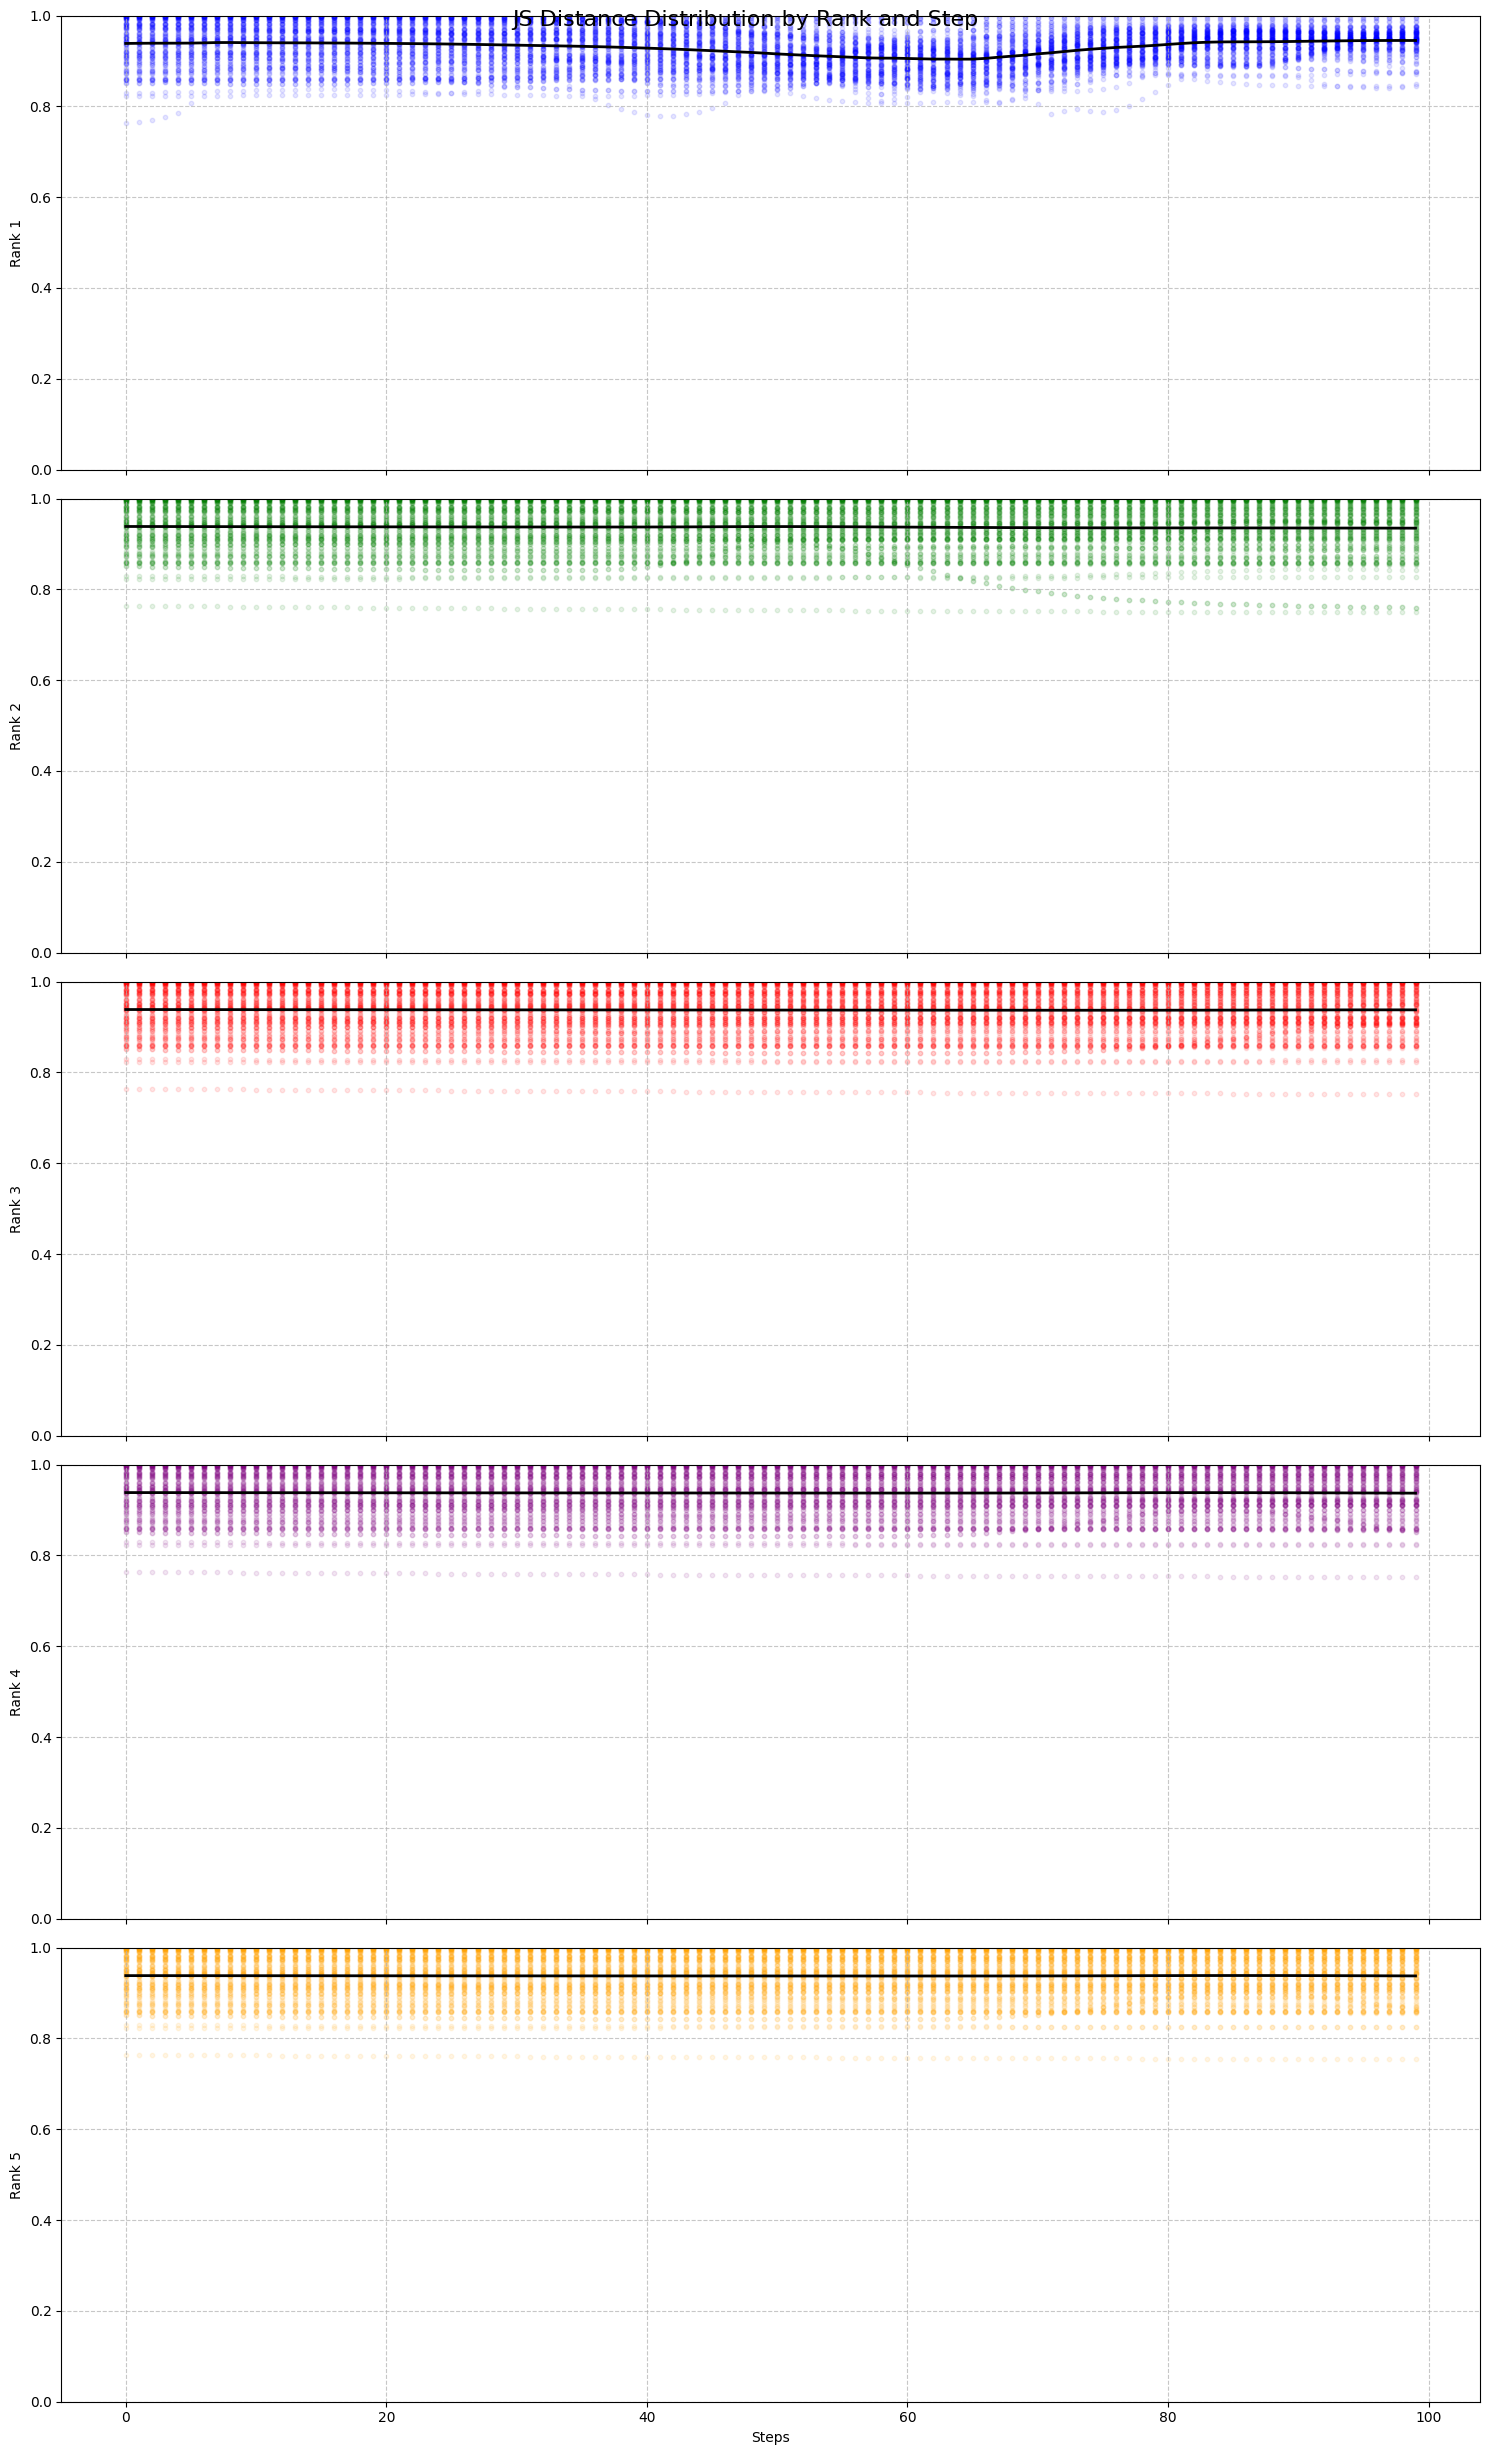

In [14]:
# Set up the plot
fig, axs = plt.subplots(5, 1, figsize=(15, 25), sharex=True)
fig.suptitle("JS Distance Distribution by Rank and Step", fontsize=16)

# Colors for each rank
colors = ["blue", "green", "red", "purple", "orange"]

for rank, (color, ax) in enumerate(zip(colors, axs), start=1):
    data = np.array(js_dist_by_rank[rank])

    # Create scatter plot
    for step in range(data.shape[1]):
        ax.scatter([step] * data.shape[0], data[:, step], color=color, alpha=0.1, s=10)

    # Calculate and plot mean line
    mean_line = np.mean(data, axis=0)
    ax.plot(range(data.shape[1]), mean_line, color="black", linewidth=2)

    ax.set_ylabel(f"Rank {rank}")
    ax.set_ylim(0, 1)  # Assuming JS distance is between 0 and 1
    ax.grid(True, linestyle="--", alpha=0.7)

# Set common x-label
axs[-1].set_xlabel("Steps")

plt.tight_layout()
plt.show()